# Reinforcement Learning: Tabular and simple network Q-Learning

This is the first notebook of a series on Reinforcement Learning. The framework used is OpenAI Gym, a set of out-of-the-box environments, from the simple Grid World to complex robotics tasks such as object manipulation. It also includes a very long list of Atari games.

OpenAI gym (pip install gym) is a very useful tool to test, develop and compare Reinforcement Learning algorithms without going crazy modeling environments that most of the time have problems. 

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Importing `gym` module is enough to load all the classes needed. `gym.make(environment)` is the command to load a specific `Env` class. An `Env` class has everything that we would expect from an environment: 
* **Observation Space** and **Action Space**: are described by the class `Space`, and can be of the type `Discrete(n)` (a single action to be chosen among n alternatives) or of the type `Box(n,)` (continuous space, with high and low bounds). Refer to [OpenAI Gym documentation](https://gym.openai.com/docs/).

Environments also have three fundamental methods:
* **`s = env.reset()`**: resets the environment, returning the initial observation;
* **`env.render()`**: renders the environment. Depending on the environment, it could print on the terminal or make a window pop out;
* **`s', r, d, i = env.step(action)`**: this command is the equivalent of a RL agent loop. It performs action a, observes reward r and state s'. `step` returns (`observation`, `reward`, `done`, `info`).

## Frozen Lake (aka GridWorld)
`FrozenLake-v0' is a 4x4 GridWorld environment. It is a MDP 16 states, which can be S (start), F (frozen), H (hole, terminates episode) and G (goal). The actions available are 4 (up, down, left, right), but the ice can be made slippery. It that case, the agent will not always move in the direction it wants: the actual move is uniformly distributed among the chosen action and the two contiguous actions (e.g., if chosen action is DOWN, the environment will pick randomly an action between (LEFT, DOWN, RIGHT)).

Reward is 0 at every step, except from stepping on G state, which rewards with 1.

In [2]:
IS_SLIPPERY = True

# print(gym.envs.registry.all())    # https://gym.openai.com/envs/#classic_control
env = gym.make('FrozenLake-v0', is_slippery=IS_SLIPPERY)
print(env.observation_space.n)
print(env.action_space.n)

16
4


In [3]:
from IPython.display import clear_output

for ep in range(2):
    s = env.reset()

    for i in range(20):
        plt.pause(1)
        clear_output(wait=True)
        env.render()

        s1, r, d, _ = env.step(env.action_space.sample())
        
        if d:
            print("Episode Ended")
            break
        

  (Left)
SFFF
FHFH
FFFH
HFFG
Episode Ended


### Q-Learning
We are going to implement tabular Q-Learning. Remember that for each episode, action is chosen greedily (or $\epsilon$-greedily - not necessary since Q-Learning is an off-policy method), while the action-value approximation is computed iteratively as $$Q(s,a) \leftarrow Q(s,a) + \alpha (r + \gamma \max Q(s', a') -Q(s,a))$$

In [4]:
# Q Table initialization
Q = np.zeros([env.observation_space.n, env.action_space.n])

# Set Learning Parameters
if IS_SLIPPERY:
    lr = 0.8
else:
    lr = .05
y = 0.95
numEpisodes = 50000
maxEpStep = 100
update = 1000
eps = 1.0
epsDecay = 1-5e-4
rList = []
rMean = []
rWindow = []

for i in range(numEpisodes):
    s = env.reset()
    rTotal = 0
    done = False
    j = 0
    eps *= epsDecay
    
    while j < maxEpStep-1:
        j += 1
        # Choose action epsilon-greedily (epsilon decreases with number of episodes)
        if IS_SLIPPERY:
            a = np.argmax(Q[s, :] + np.random.randn(env.action_space.n)*(1./(i+1)))
        else:
            if np.random.uniform(0, 1, 1) < eps:
                a = np.random.randint(0, 3, 1)[0]
            else:
                a = np.argmax(Q[s, :])
         
        s1, r, done, info = env.step(a)
        
        Q[s, a] = Q[s, a] + lr*(r + y*np.max(Q[s1, :]) - Q[s, a])
        rTotal += r
        s = s1
        if done:
            break
    
    rList.append(rTotal)
    rMean.append(np.mean(rList))
    rWindow.append(np.mean(rList[-1000:]))
    if i % update == 0:
        print("Episode " + str(i) + ", Average Success Rate: " + str(rMean[i]) + ", Exploration rate: " + str(eps))

Episode 0, Average Success Rate: 0.0, Exploration rate: 0.9995
Episode 1000, Average Success Rate: 0.34165834165834164, Exploration rate: 0.606151595428677
Episode 2000, Average Success Rate: 0.44427786106946526, Exploration rate: 0.36760355841993914
Episode 3000, Average Success Rate: 0.4915028323892036, Exploration rate: 0.22293495089695248
Episode 4000, Average Success Rate: 0.5161209697575606, Exploration rate: 0.1351999761510762
Episode 5000, Average Success Rate: 0.5310937812437513, Exploration rate: 0.08199267758468616
Episode 6000, Average Success Rate: 0.5447425429095151, Exploration rate: 0.04972485475880578
Episode 7000, Average Success Rate: 0.5470647050421369, Exploration rate: 0.030155877983500955
Episode 8000, Average Success Rate: 0.5458067741532309, Exploration rate: 0.018288177640071544
Episode 9000, Average Success Rate: 0.546717031440951, Exploration rate: 0.011090953530777752
Episode 10000, Average Success Rate: 0.5500449955004499, Exploration rate: 0.0067261622586

The agent is learning to reach the goal in the environment, but due to the stochasticity of the FrozenLake environment, no optimal solution exists. But it keeps learning and refining the policy.

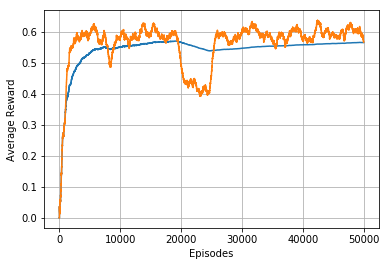

In [5]:
# Plot results.
plt.plot(rMean)
plt.plot(rWindow)
plt.grid()
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.show()

In [6]:
print(Q)

[[1.76702738e-01 2.73284075e-03 2.65135246e-03 2.81821379e-03]
 [1.37336535e-04 3.07735586e-04 3.57289021e-04 4.74622981e-02]
 [3.49855713e-04 1.27687809e-04 5.69998515e-04 3.87877764e-02]
 [2.65465318e-04 1.38943691e-04 1.21413592e-04 3.70431472e-02]
 [1.80526438e-01 2.83670097e-04 8.31219301e-04 7.59692520e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [9.61990082e-03 6.61281194e-06 6.31884801e-07 1.02109872e-08]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.91875079e-04 2.27291743e-04 5.85165124e-04 2.53167438e-01]
 [4.47987051e-04 1.46073083e-01 1.57950015e-04 0.00000000e+00]
 [6.11563731e-02 5.17113689e-05 3.15128266e-05 8.60704569e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.72288565e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.54030895e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.000000

#### Learned Policy Evaluation

In [7]:
rList = []

# evaluate learned policy over 1000 episodes
for i in range(1000):
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    
    while j < maxEpStep-1:
        j += 1
        # Choose action greedily with noise
        a = np.argmax(Q[s, :])
        s1, r, d, info = env.step(a)
        rAll += r
        s = s1
        if d == True:
            break
    #jList.append(j)
    rList.append(rAll)
    
print("Accuracy: " + str(np.sum(rList)/1000))

Accuracy: 0.595


## Q-Learning with Neural Networks (Q-Network Learning)
In order to extend algorithms working on tabular methods to much more complex problems, it is necessary to introduce function approximation. In particular, it is necessary to define an approximator $Q_{\phi}(s,a)$, where $\phi$ indicate the weights of the network, for the action-value function $Q(s,a)$. This can be done with a neural network. In this case the network will be super simple, but the concept will help us develop much more complex networks in the future.


The network has just one fully connected layer, connecying the input $s$ (a one-hot vector encoding of the state, 16-dimensional) and the output, a 4-dimensional vector representing $Q_{\phi}(s, a)$. This generates a network with 16$\times$4 weights, which replace the tabular entries.

The update of the network is not the standard Q-Learning anymore, but it is based on backpropagation of the loss function, which is chosen as the squared error: $$L = \sum_a (Q_{\phi}(s,a))^2-y(s,a)),$$

where $y(s,a)$ is the target, defined in such a way that by minimizing $L$, $Q_{\phi}(s,a)$ will approach $$y(s,a)=r(s,a)+\gamma\max_{a'} Q_{\phi}(s',a'),$$

which is the goal of Q-learning.

In [8]:
import random
import tensorflow as tf
    
tf.reset_default_graph() 

class Qnet():
    def __init__(self):
        self.inputs1 = tf.placeholder(shape=[None, 16], dtype=tf.float32)
        self.W = tf.Variable(tf.random_uniform([16,4], 0, 0.01))
        self.Qout = tf.matmul(self.inputs1, self.W)
        self.predict = tf.argmax(self.Qout, 1)
        self.targetQ = tf.placeholder(shape=[None, 4], dtype=tf.float32)
        self.loss = tf.reduce_sum(tf.square(self.targetQ - self.Qout))
        self.updateModel = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(self.loss)
    

/home/federico/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/federico/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/federico/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/federico/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [9]:
# Train the network

DQN = Qnet()
init = tf.global_variables_initializer()

y = 0.99
e = 0.1
# num_episodes = 2000

jList = []
rList_net = []
meanReward_net = []

with tf.Session() as sess:
    sess.run(init)
#     print(sess.run(DQN.Qout, feed_dict={DQN.inputs1: np.identity(16)[0:1]}))
    for i in range(numEpisodes):
        s = env.reset()
        totalReward = 0
        done = False
        j = 1
        while j < 99:
            j += 1
            
            # e-greedy action
            a, allQ = sess.run([DQN.predict, DQN.Qout], feed_dict={DQN.inputs1: np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
                
            s1, r, done, info = env.step(a[0])
            Q1 = sess.run(DQN.Qout, feed_dict={DQN.inputs1: np.identity(16)[s1:s1+1]})
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0, a[0]] = r + y*maxQ1
            _ = sess.run(DQN.updateModel, feed_dict={DQN.inputs1: np.identity(16)[s:s+1], DQN.targetQ: targetQ})
            totalReward += r
            
            s = s1
            if done:
                e = 1./((i/50) + 10)
                break

        jList.append(j)
        rList_net.append(totalReward)
        meanReward_net.append(np.sum(rList_net)/(i+1))
        if i % update == 0:
            print("Episode: " + str(i) + ", average reward: " + str(meanReward_net[i]))
#             print(Q1)

print("Rate of successful episodes: " + str(sum(rList_net)/numEpisodes))

Episode: 0, average reward: 0.0
Episode: 1000, average reward: 0.32967032967032966
Episode: 2000, average reward: 0.42278860569715143
Episode: 3000, average reward: 0.48817060979673443
Episode: 4000, average reward: 0.5266183454136466
Episode: 5000, average reward: 0.5576884623075385
Episode: 6000, average reward: 0.5762372937843693
Episode: 7000, average reward: 0.5924867876017712
Episode: 8000, average reward: 0.6011748531433571
Episode: 9000, average reward: 0.6093767359182313
Episode: 10000, average reward: 0.6166383361663834
Episode: 11000, average reward: 0.6233978729206435
Episode: 12000, average reward: 0.6287809349220899
Episode: 13000, average reward: 0.6350280747634798
Episode: 14000, average reward: 0.6387400899935719
Episode: 15000, average reward: 0.6424905006332912
Episode: 16000, average reward: 0.6453971626773327
Episode: 17000, average reward: 0.6496676666078466
Episode: 18000, average reward: 0.6516304649741681
Episode: 19000, average reward: 0.6532287774327667
Episo

In [ ]:
plt.plot(rMean, 'r', label="Tabular")
plt.plot(meanReward_net, 'b', label="DQN")
plt.grid()
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.show()

After about 1000 episodes the network starts to learn the correct path. Even if the network is the simplest network possible and there is no Experience Replay, Batch Training and target networks, it converges to a solution really close to the one found with the tabular solution.